In [3]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
 97% 1.46G/1.52G [00:11<00:00, 109MB/s] 
100% 1.52G/1.52G [00:11<00:00, 144MB/s]


In [4]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tqdm import tqdm
import shutil

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Define paths
inputFolder = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
outputFolder = "/content/Output"

# Create directory structure
for split in ['train', 'validation', 'test']:
    for class_name in ['Normal', 'Cyst', 'Tumor', 'Stone']:
        os.makedirs(os.path.join(outputFolder, split, class_name), exist_ok=True)

In [6]:
# Prepare data paths and labels
class_names = sorted(os.listdir(inputFolder))
file_paths = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(inputFolder, class_name)
    for filename in os.listdir(class_path):
        file_paths.append(os.path.join(class_path, filename))
        labels.append(class_idx)

# Stratified train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [7]:
# Function to copy files to respective directories
def copy_files(file_paths, labels, split_name):
    for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths), desc=f"Copying {split_name} files"):
        class_name = class_names[label]
        filename = os.path.basename(file_path)
        dest_path = os.path.join(outputFolder, split_name, class_name, filename)
        shutil.copy(file_path, dest_path)

# Execute copying
copy_files(X_train, y_train, 'train')
copy_files(X_val, y_val, 'validation')
copy_files(X_test, y_test, 'test')

Copying test files: 100%|██████████| 1867/1867 [00:00<00:00, 1946.98it/s]


In [8]:
# Setup augmentation
target_size = (299, 299)  # InceptionV3 requires 299x299 input
aug_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='reflect'
)

# Generate augmented images
num_augmentations = 5
print("Generating augmented images for training...")
for file_path, label in tqdm(zip(X_train, y_train), total=len(X_train), desc="Augmenting training images"):
    class_name = class_names[label]
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    i = 0
    for batch in aug_datagen.flow(img_array, batch_size=1,
                                 save_to_dir=os.path.join(outputFolder, 'train', class_name),
                                 save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= num_augmentations:
            break

Generating augmented images for training...


Augmenting training images: 100%|██████████| 8712/8712 [16:58<00:00,  8.55it/s]


In [9]:
# Print dataset statistics
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} Split:")
    total = 0
    for class_name in class_names:
        path = os.path.join(outputFolder, split, class_name)
        num_images = len(os.listdir(path))
        print(f"{class_name}: {num_images} images")
        total += num_images
    print(f"Total {split} images: {total}")

# Calculate class weights
class_counts = np.bincount(labels)
total_samples = sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

print("\nClass Weights:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_weights[i]:.4f}")


Train Split:
Cyst: 9828 images
Normal: 11856 images
Stone: 4763 images
Tumor: 7098 images
Total train images: 33545

Validation Split:
Cyst: 556 images
Normal: 762 images
Stone: 206 images
Tumor: 343 images
Total validation images: 1867

Test Split:
Cyst: 557 images
Normal: 761 images
Stone: 207 images
Tumor: 342 images
Total test images: 1867

Class Weights:
Cyst: 0.8389
Normal: 0.6129
Stone: 2.2596
Tumor: 1.3629


In [10]:
# Create data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    os.path.join(outputFolder, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(outputFolder, 'validation'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(outputFolder, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.n}")
print(f"Validation samples: {val_generator.n}")
print(f"Test samples: {test_generator.n}")

Found 33545 images belonging to 4 classes.
Found 1867 images belonging to 4 classes.
Found 1867 images belonging to 4 classes.

Training samples: 33545
Validation samples: 1867
Test samples: 1867


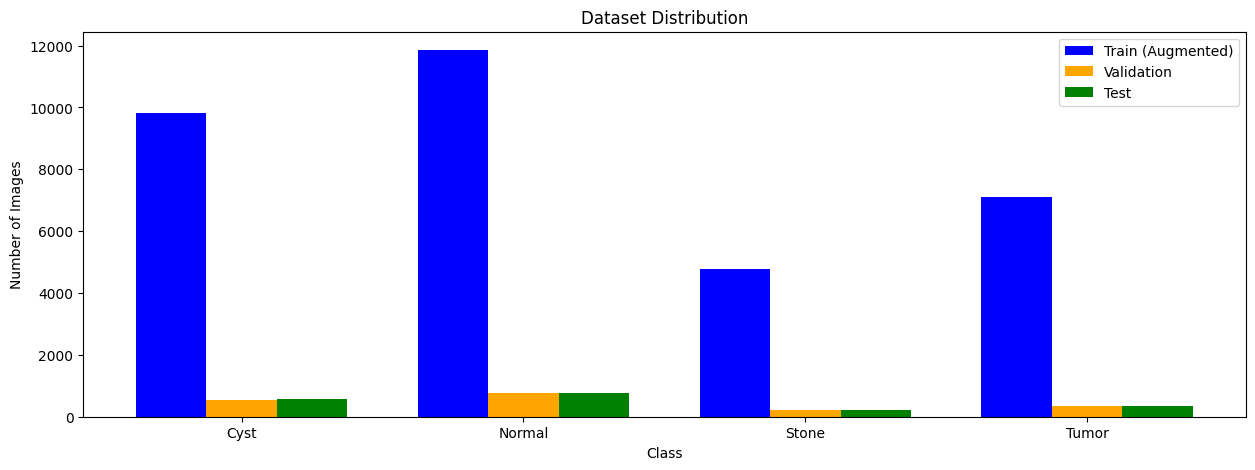

In [11]:
# Visualize data distribution
plt.figure(figsize=(15, 5))
train_counts = [len(os.listdir(os.path.join(outputFolder, 'train', class_name))) for class_name in class_names]
val_counts = [len(os.listdir(os.path.join(outputFolder, 'validation', class_name))) for class_name in class_names]
test_counts = [len(os.listdir(os.path.join(outputFolder, 'test', class_name))) for class_name in class_names]

x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, train_counts, width, label='Train (Augmented)', color='blue')
plt.bar(x, val_counts, width, label='Validation', color='orange')
plt.bar(x + width, test_counts, width, label='Test', color='green')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.xticks(x, class_names)
plt.legend()
plt.show()

In [12]:
# Build InceptionV3 model with partial unfreezing
def create_inception_model():
    # Load pre-trained InceptionV3 base
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )

    # Freeze first 150 layers, unfreeze deeper layers
    base_model.trainable = True  # Enable trainability first
    for layer in base_model.layers[:150]:
        layer.trainable = False  # Freeze early layers

    # Print freezing statistics
    total_layers = len(base_model.layers)
    trainable_layers = sum([layer.trainable for layer in base_model.layers])
    print(f"Unfrozen layers: {trainable_layers}/{total_layers} (≈{trainable_layers/total_layers:.1%})")

    # Build custom head
    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = base_model(inputs, training=True)  # Important: training=True for BN layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Compile with adjusted LR for fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Reduced from 0.0005
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Create and inspect model
model = create_inception_model()

# Detailed summary
print("\nModel Summary:")
model.summary()

# Parameter report
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f"\nTrainable params: {trainable_params:,}")
print(f"Non-trainable params: {non_trainable_params:,}")
print(f"Total params: {trainable_params + non_trainable_params:,}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Unfrozen layers: 161/311 (≈51.8%)

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,909,156 (91.21 MB)

 Trainable params: 19,471,300 (74.28 MB)

 Non-trainable params: 4,437,856 (16.93 MB)


Trainable params: 19,471,300
Non-trainable params: 4,437,856
Total params: 23,909,156


In [13]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True,verbose=1),
    ModelCheckpoint('best_inception_model.keras', save_best_only=True, monitor='val_loss',verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7,verbose=1)
]

# Start training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7905 - auc: 0.9376 - loss: 0.6256
Epoch 1: val_loss improved from inf to 0.03219, saving model to best_inception_model.keras
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 358s 293ms/step - accuracy: 0.7906 - auc: 0.9377 - loss: 0.6253 - val_accuracy: 0.9893 - val_auc: 0.9998 - val_loss: 0.0322 - learning_rate: 1.0000e-04
Epoch 2/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9822 - auc: 0.9989 - loss: 0.0545
Epoch 2: val_loss improved from 0.03219 to 0.01049, saving model to best_inception_model.keras
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 301s 241ms/step - accuracy: 0.9822 - auc: 0.9989 - loss: 0.0545 - val_accuracy: 0.9957 - val_auc: 1.0000 - val_loss: 0.0105 - learning_rate: 1.0000e-04
Epoch 3/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9901 - auc: 0.9993 - loss: 0.0314
Epoch 3: val_loss improved from 0.01049 to 0.00222, saving model to best_inception_model.keras
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 267s 246ms

59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 302ms/step


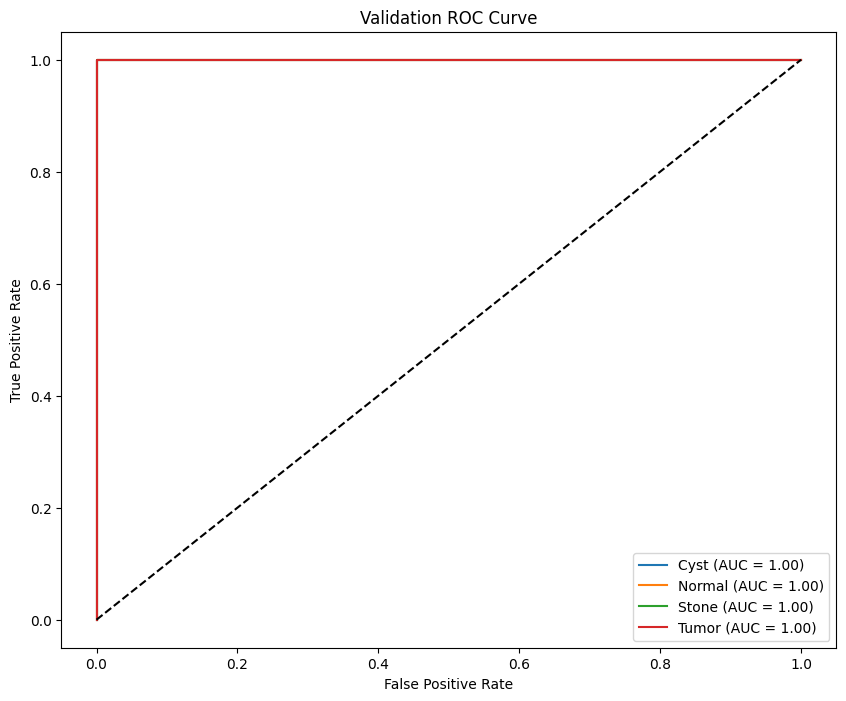

In [14]:
# Load best model
best_model = tf.keras.models.load_model('best_inception_model.keras')

# Validation predictions
y_pred = best_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# ROC Curve for validation
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'{name} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend()
plt.show()

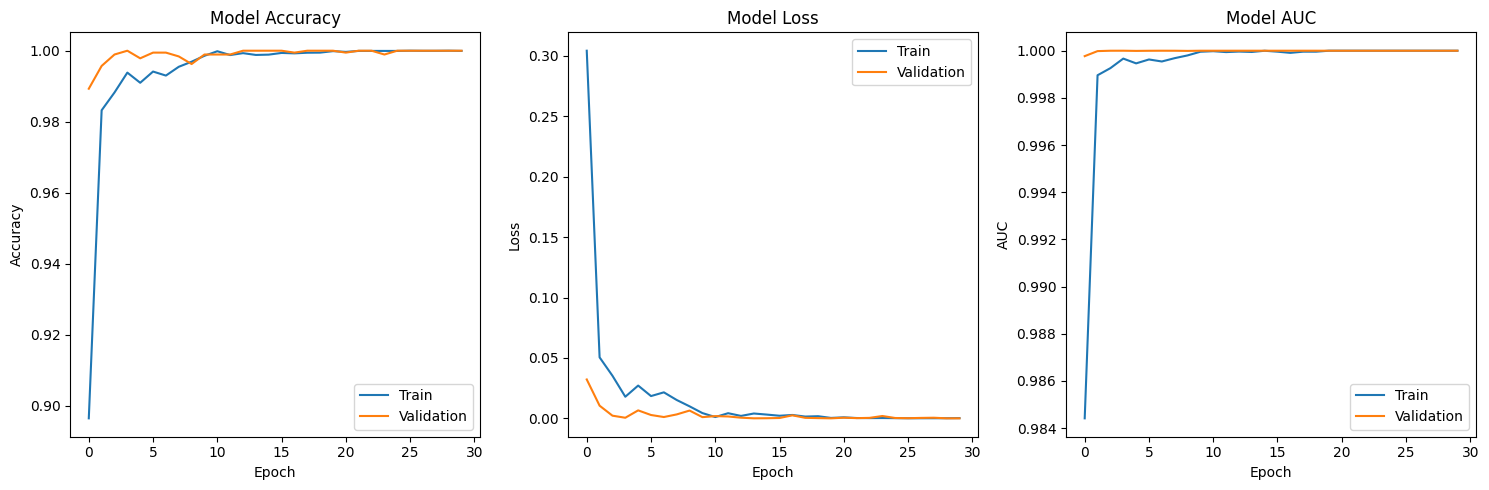

In [15]:
# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Validation')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - accuracy: 0.9997 - auc: 0.9998 - loss: 0.0027

Test Evaluation:
Loss: 0.0097
Accuracy: 0.9989
AUC: 0.9993
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step


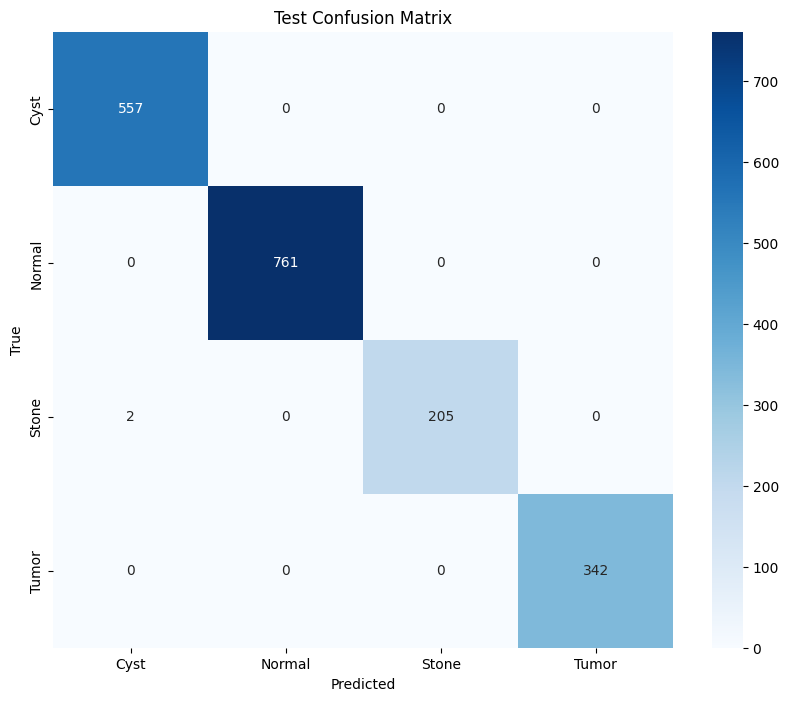


Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       557
      Normal       1.00      1.00      1.00       761
       Stone       1.00      0.99      1.00       207
       Tumor       1.00      1.00      1.00       342

    accuracy                           1.00      1867
   macro avg       1.00      1.00      1.00      1867
weighted avg       1.00      1.00      1.00      1867



In [16]:
# Evaluate on test set
test_loss, test_accuracy, test_auc = best_model.evaluate(test_generator)
print(f"\nTest Evaluation:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")

# Test predictions
y_test_pred = best_model.predict(test_generator)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = test_generator.classes

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(y_test_true, y_test_pred_classes),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=class_names))

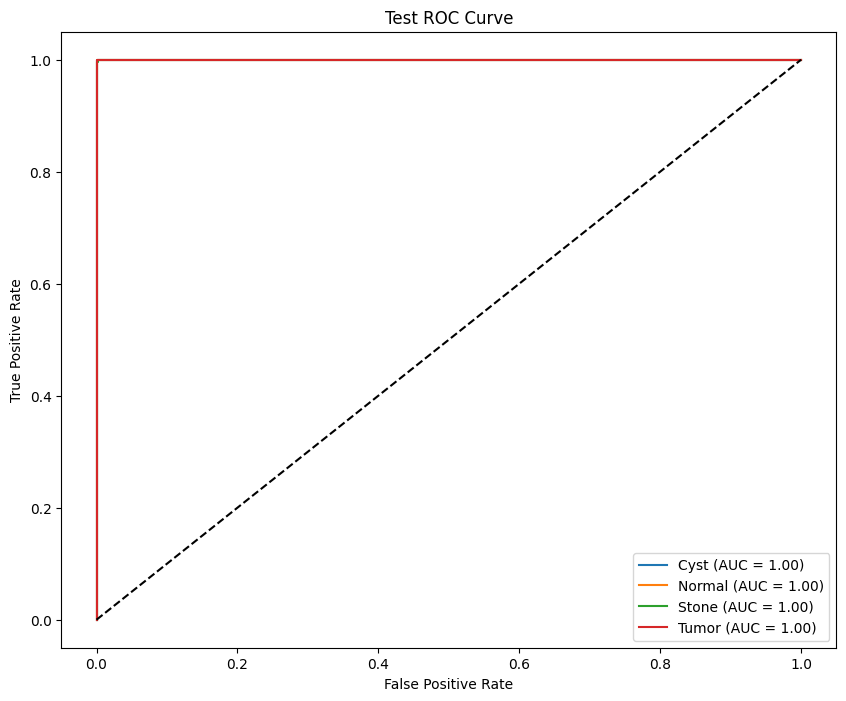

In [17]:
# ROC Curve for test set
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(len(class_names)):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_true == i, y_test_pred[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    plt.plot(fpr_test[i], tpr_test[i], label=f'{name} (AUC = {roc_auc_test[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend()
plt.show()

Sample Predictions:


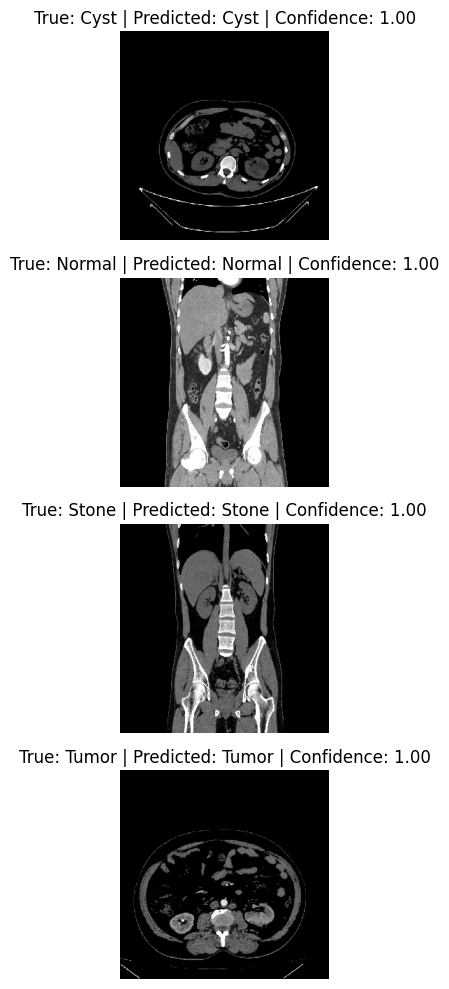

In [18]:
# Visualize sample predictions
def predict_per_class_samples(model, generator, class_names):
    generator.reset()
    images, true_labels = [], []
    found_classes = set()

    # Get one sample per class
    while len(found_classes) < len(class_names):
        batch_x, batch_y = next(generator)
        for img, lbl in zip(batch_x, batch_y):
            cls_idx = np.argmax(lbl)
            if cls_idx not in found_classes:
                images.append(img)
                true_labels.append(lbl)
                found_classes.add(cls_idx)
            if len(found_classes) >= len(class_names):
                break

    # Plot predictions
    plt.figure(figsize=(15, 10))
    for i, (img, lbl) in enumerate(zip(images, true_labels)):
        # Reverse preprocessing for display
        img_display = img / 2.0 + 0.5
        true_label = class_names[np.argmax(lbl)]
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
        pred_label = class_names[np.argmax(pred)]
        confidence = np.max(pred)

        plt.subplot(len(class_names), 1, i+1)
        plt.imshow(img_display)
        plt.title(f'True: {true_label} | Predicted: {pred_label} | Confidence: {confidence:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample Predictions:")
predict_per_class_samples(best_model, test_generator, class_names)